# 3D printēta deformācijas sensora datu analīze

## Datu priekšapstrāde

### Datu kopas ielasīšana un attēlošana

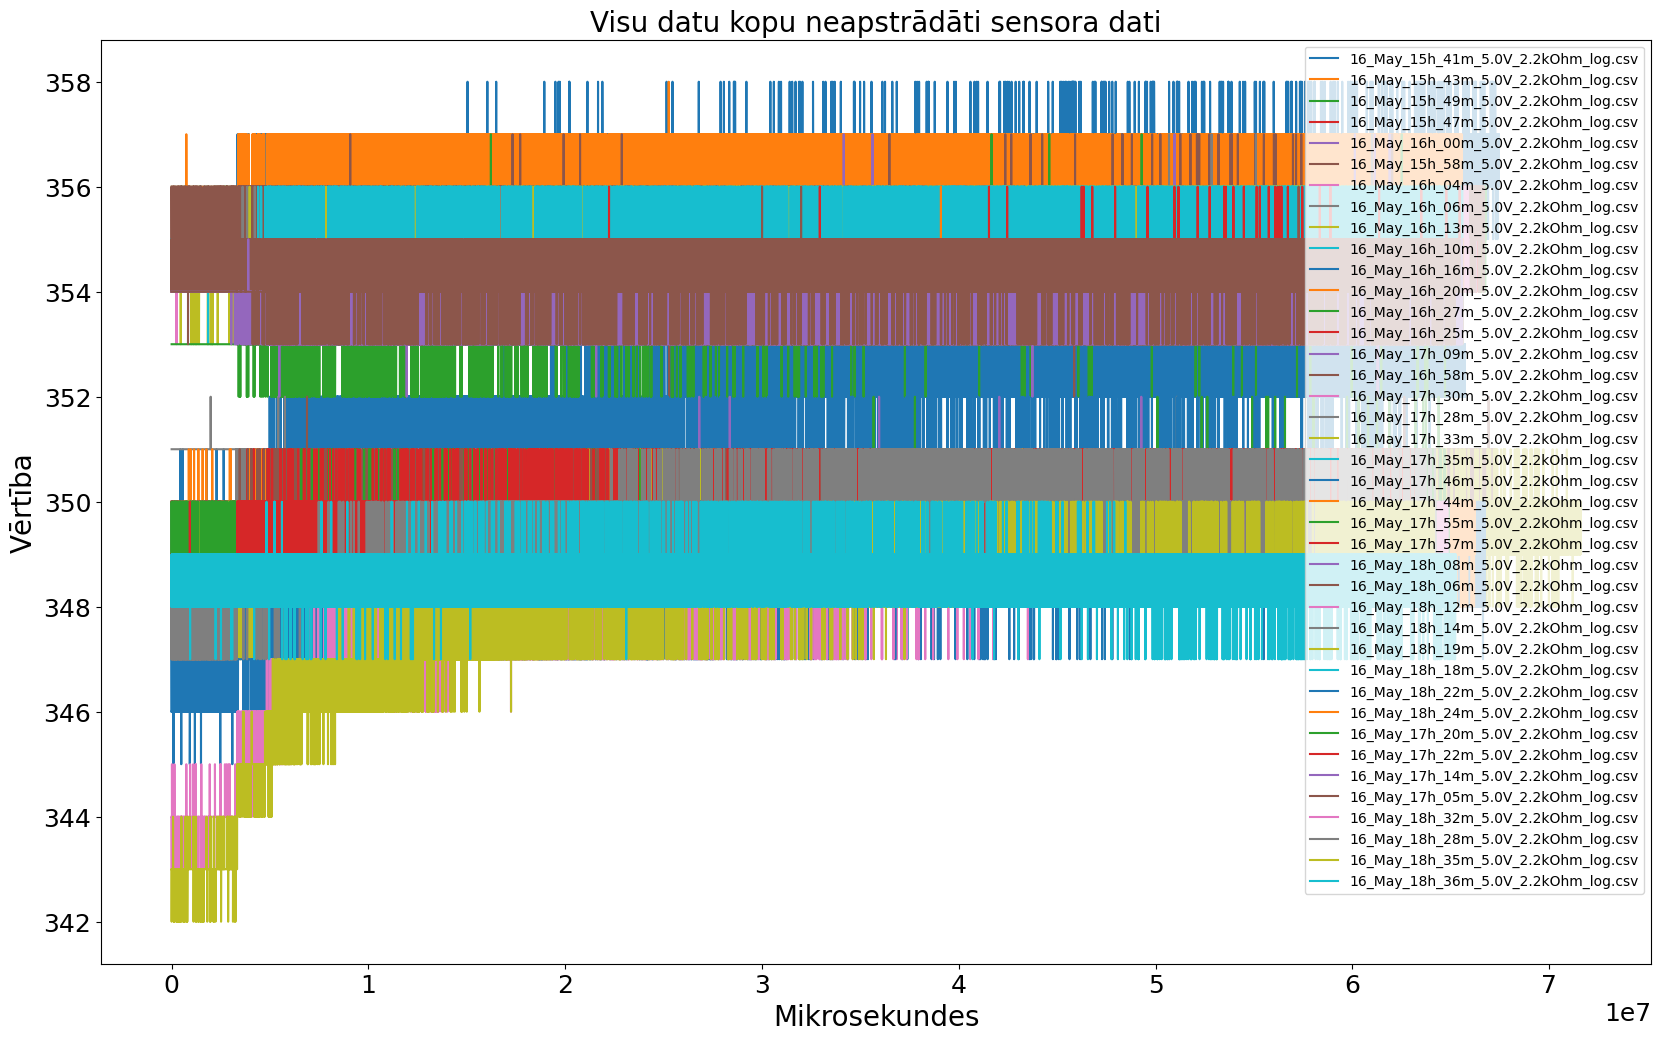

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.fftpack
import os
import itertools
from scipy.stats import zscore, skew, kurtosis
from scipy.signal import welch
import seaborn as sbn

# Failu datu kopa
file_list = [
    "16_May_15h_41m_5.0V_2.2kOhm_log.csv",
    "16_May_15h_43m_5.0V_2.2kOhm_log.csv",
    "16_May_15h_49m_5.0V_2.2kOhm_log.csv",
    "16_May_15h_47m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_00m_5.0V_2.2kOhm_log.csv",
    "16_May_15h_58m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_04m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_06m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_13m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_10m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_16m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_20m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_27m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_25m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_09m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_58m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_30m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_28m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_33m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_35m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_46m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_44m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_55m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_57m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_08m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_06m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_12m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_14m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_19m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_18m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_22m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_24m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_20m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_22m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_14m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_05m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_32m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_28m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_35m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_36m_5.0V_2.2kOhm_log.csv"
]

plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'xtick.labelsize': 18, 'ytick.labelsize': 18})

# Grafiks
for file in file_list:
    data = pd.read_csv(file)
    microseconds = data['Microseconds'].values
    value = data['Value'].values
    plt.plot(microseconds, value, label=file)

plt.title('Visu datu kopu neapstrādāti sensora dati', fontsize=20)
plt.xlabel('Mikrosekundes', fontsize= 20)
plt.ylabel('Vērtība', fontsize= 20)
plt.legend(loc='upper right')

plt.show()



In [2]:
# Iztrūkstošo vērtību pārbaude

for file in file_list:
    print(f"File: {file}")
    dataset = pd.read_csv(file)
    print(dataset.info())
    print('\n')

File: 16_May_15h_41m_5.0V_2.2kOhm_log.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501278 entries, 0 to 501277
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Microseconds  501278 non-null  int64
 1   Value         501278 non-null  int64
dtypes: int64(2)
memory usage: 7.6 MB
None


File: 16_May_15h_43m_5.0V_2.2kOhm_log.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486672 entries, 0 to 486671
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Microseconds  486672 non-null  int64
 1   Value         486672 non-null  int64
dtypes: int64(2)
memory usage: 7.4 MB
None


File: 16_May_15h_49m_5.0V_2.2kOhm_log.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497500 entries, 0 to 497499
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Microseconds  497500 non-null

### Datu normalizācija

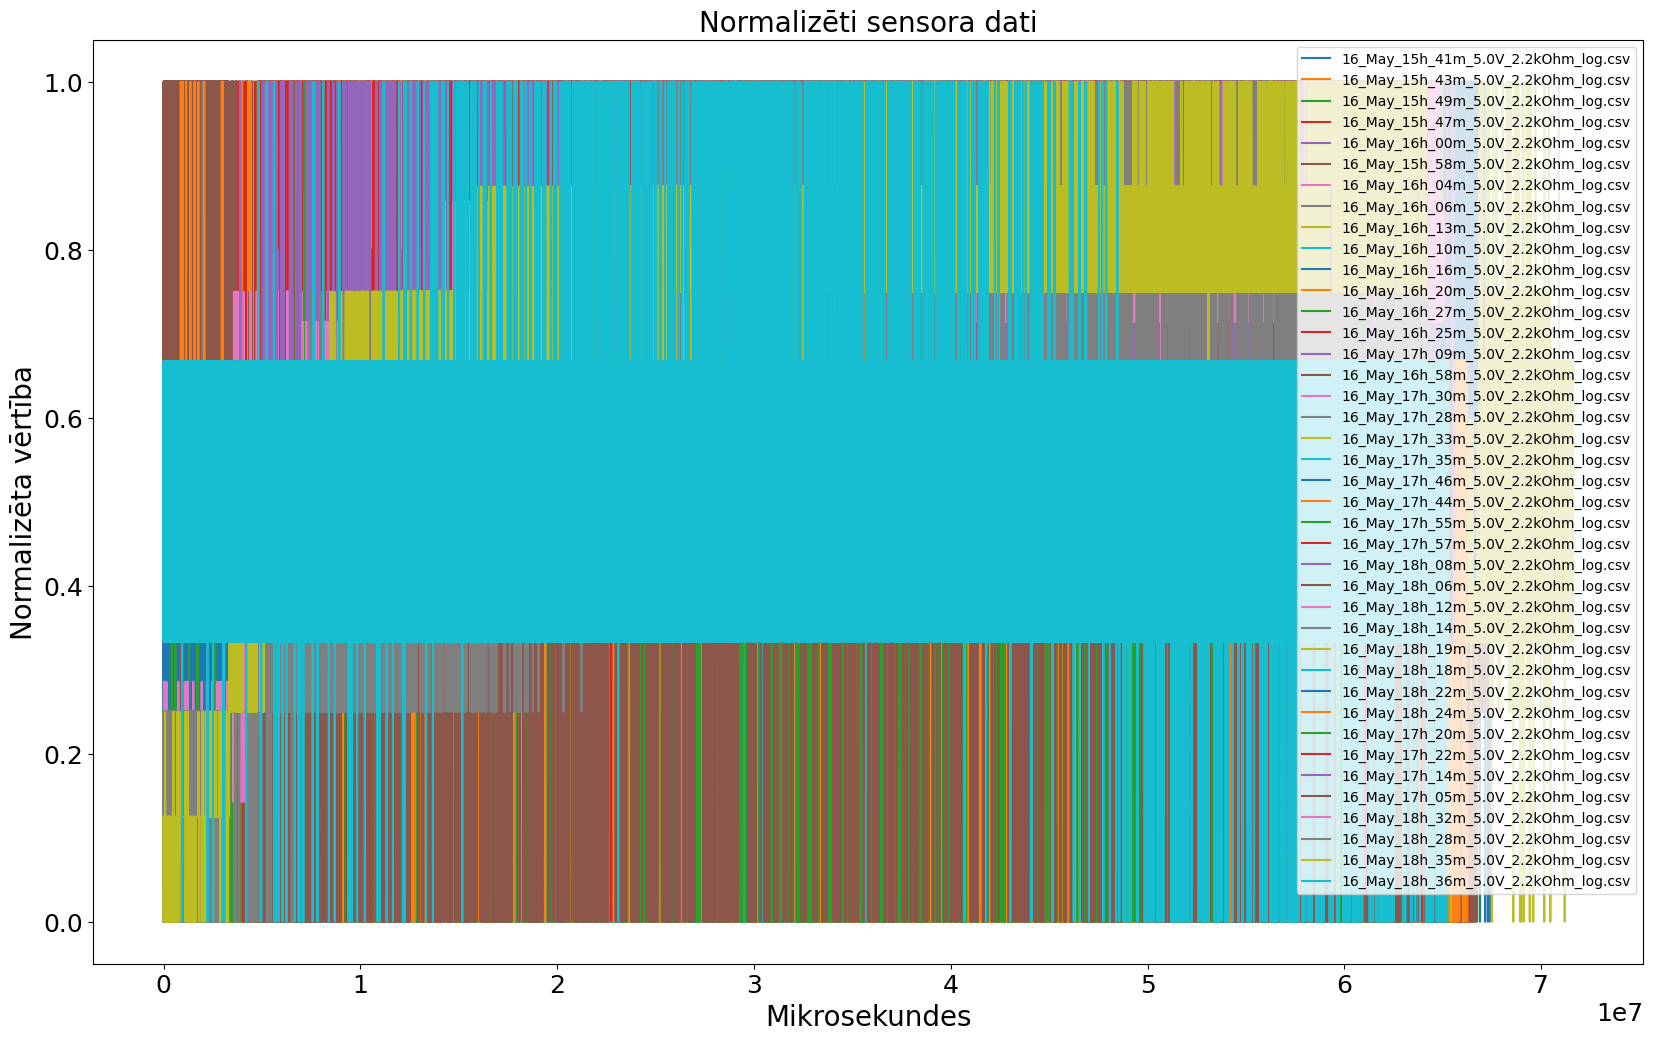

In [3]:
# Funkcija datu normalizācijai
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Normalizētu datu grafiks
for file in file_list:
    data = pd.read_csv(file)
    microseconds = data['Microseconds'].values
    value = data['Value'].values
    normalized_value = normalize(value)
    plt.plot(microseconds, normalized_value, label=file)

plt.title('Normalizēti sensora dati', fontsize= 20)
plt.xlabel('Mikrosekundes', fontsize= 20)
plt.ylabel('Normalizēta vērtība', fontsize= 20)
plt.legend(loc='upper right')
plt.show()


### Vidējās mērījumu frekvences aprēķināšana

In [4]:
# Vidējā mērījumu frekvence katram failam
average_sampling_freq_file = []

for file in file_list:
    data = pd.read_csv(file)
    period = data['Microseconds'].diff().mean()

    # f = 1 / T
    average_sampling_freq = 1 / (period / 1e6)

    average_sampling_freq_file.append(average_sampling_freq)

dataset_sampling_freq = sum(average_sampling_freq_file) / len(average_sampling_freq_file)

print(f"Datu kopas vidējā mērījumu frekvence: {dataset_sampling_freq} Hz\n")


Datu kopas vidējā mērījumu frekvence: 7420.8949777641365 Hz



### Datu pārveidošana frekvenču domēnā, izmantojot ātro Furjē transformāciju

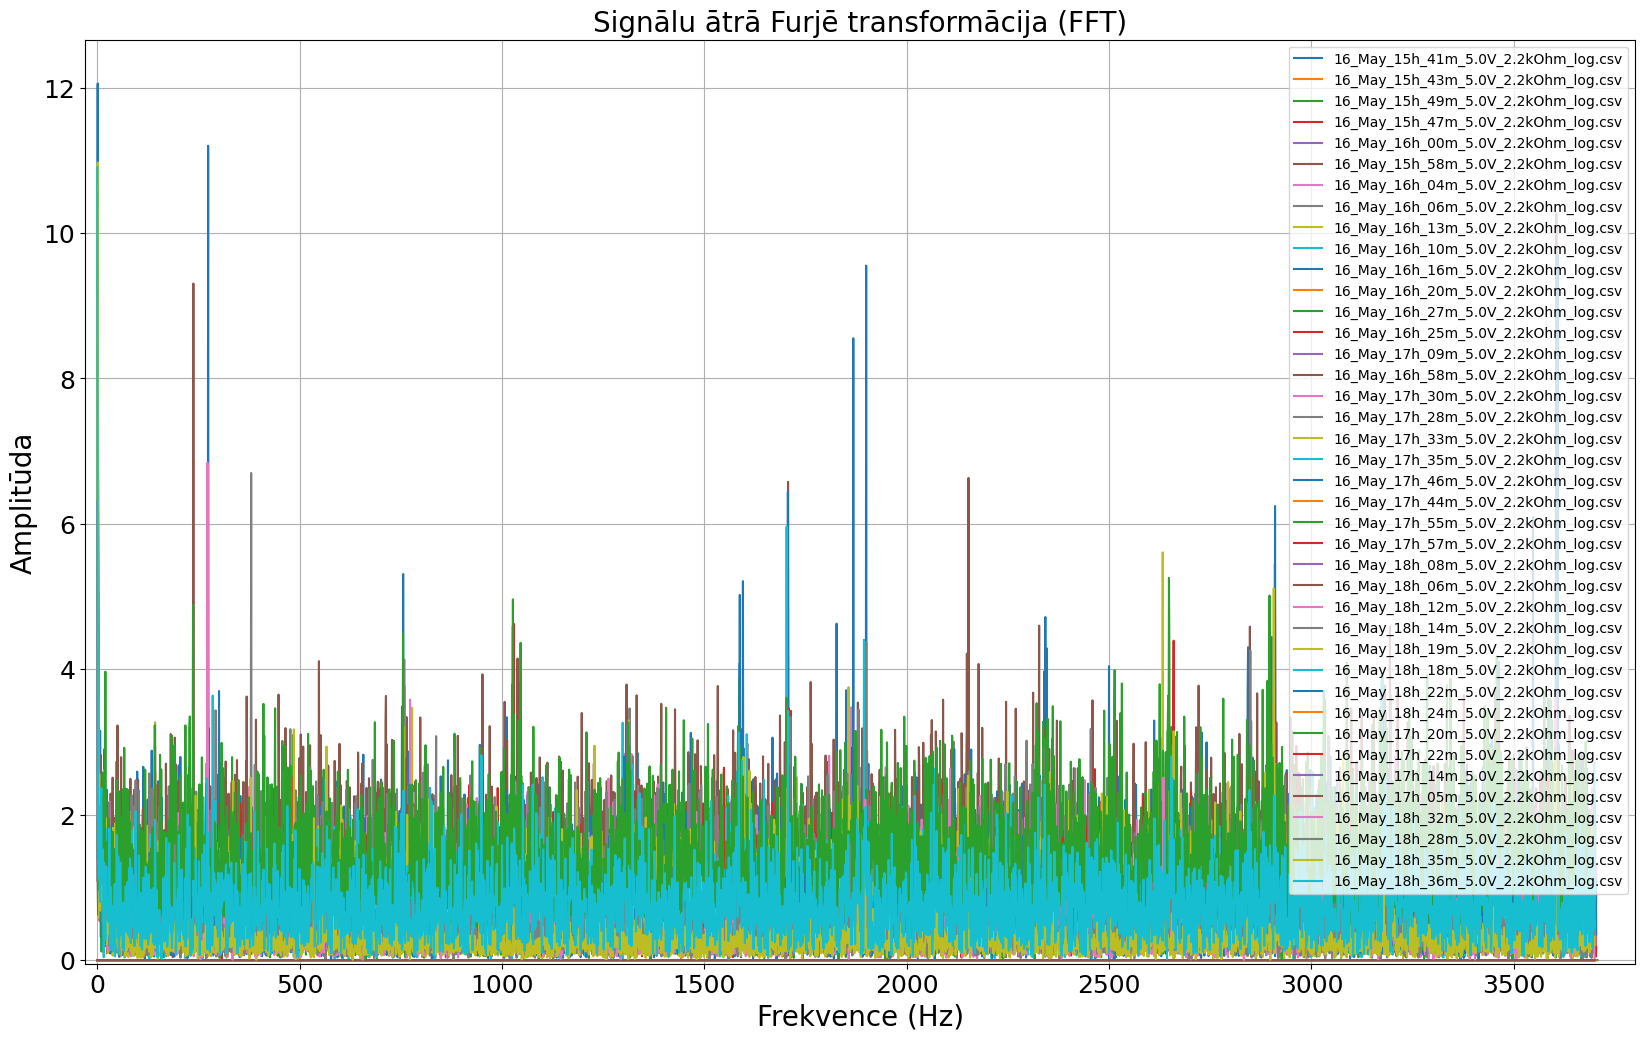

In [5]:
# Funkcija, lai aprēķinātu FFT pa fragmentiem, kas tiek vidējoti
def average_fft_segments(data, segment_size):
    num_segments = len(data) // segment_size
    averaged_fft = np.zeros(segment_size // 2 + 1, dtype=np.complex128)

    for i in range(num_segments):
        segment = data[i * segment_size : (i + 1) * segment_size]
        fft_result = np.fft.rfft(segment)
        averaged_fft += fft_result

    return averaged_fft / num_segments

# Nosaka īsākā signāla garumu
shortest_length = 0
for file in file_list:
    data = pd.read_csv(file)
    values = data['Value'].values
    if shortest_length == 0 or len(values) < shortest_length:
        shortest_length = len(values)

# FFT fragmentu garums
segment_size = 7420

for file in file_list:
    data = pd.read_csv(file)
    microseconds = data['Microseconds'].values
    values = data['Value'].values

    # Signālu saīsināšana līdz vienādam garumam
    values = values[:shortest_length]

    values = normalize(values)

    # Izlēcošo vērtību noņemšana, balstoties uz z vērtību
    z_scores = zscore(values)
    values = values[np.abs(z_scores) < 3]

    # Signāla līdzkomponentes atņemšana
    values = values - np.mean(values)

    # Mērījumu frekvences aprēķināšana
    time_between_samples = np.diff(microseconds[:shortest_length])
    sampling_period = np.mean(time_between_samples) / 1e6

    # Vidējais fragmentu FFT
    averaged_fft = average_fft_segments(values, segment_size)
    freq = np.fft.rfftfreq(segment_size, d=sampling_period)

    plt.plot(freq, np.abs(averaged_fft), label=file)

plt.title('Signālu ātrā Furjē transformācija (FFT)', fontsize= 20)
plt.xlabel('Frekvence (Hz)', fontsize= 20)
plt.ylabel('Amplitūda', fontsize= 20)
plt.xlim(-30, 3800)
plt.ylim(bottom=-0.05)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Iezīmju iegūšana

In [6]:
# Datu kopas pazīmes
labels = [
    [1, 1, 1], [0, 1, 1], [1, 0, 1], [0, 0, 1],
    [1, 1, 1], [0, 1, 1], [1, 0, 1], [0, 0, 1],
    [1, 1, 1], [0, 1, 1], [1, 0, 1], [0, 0, 1],
    [1, 1, 0], [0, 1, 0], [1, 0, 0], [0, 0, 0],
    [1, 1, 0], [0, 1, 0], [1, 0, 0], [0, 0, 0],
    [1, 1, 1], [0, 1, 1], [1, 0, 1], [0, 0, 1],
    [1, 1, 1], [0, 1, 1], [1, 0, 1], [0, 0, 1],
    [1, 1, 1], [0, 1, 1], [1, 0, 1], [0, 0, 1],
    [1, 1, 0], [0, 1, 0], [1, 0, 0], [0, 0, 0],
    [1, 1, 0], [0, 1, 0], [1, 0, 0], [0, 0, 0]
]

### Nolietots motors

Features 16_May_15h_41m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 3.63233595703085e-05, 'Minimālā vērtība': 5.891728319002347e-06, 'Maksimālā vērtība': 0.00019117015828424877, 'Ekscess': 32.384700373970325, 'Asimetrija': 4.8733336029280725, 'Standartnovirze': 1.6560351230040787e-05, 'Vidējā kvadrātiskā vērtība': 3.992031667379701e-05, 'Diapazons': 0.00018527842996524641}
Features 16_May_15h_43m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Standartnovirze': 0.0, 'Vidējā kvadrātiskā vērtība': 0.0, 'Diapazons': 0.0}
Features 16_May_15h_49m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Standartnovirze': 0.0, 'Vidējā kvadrātiskā vērtība': 0.0, 'Diapazons': 0.0}
Features 16_May_15h_47m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Stan

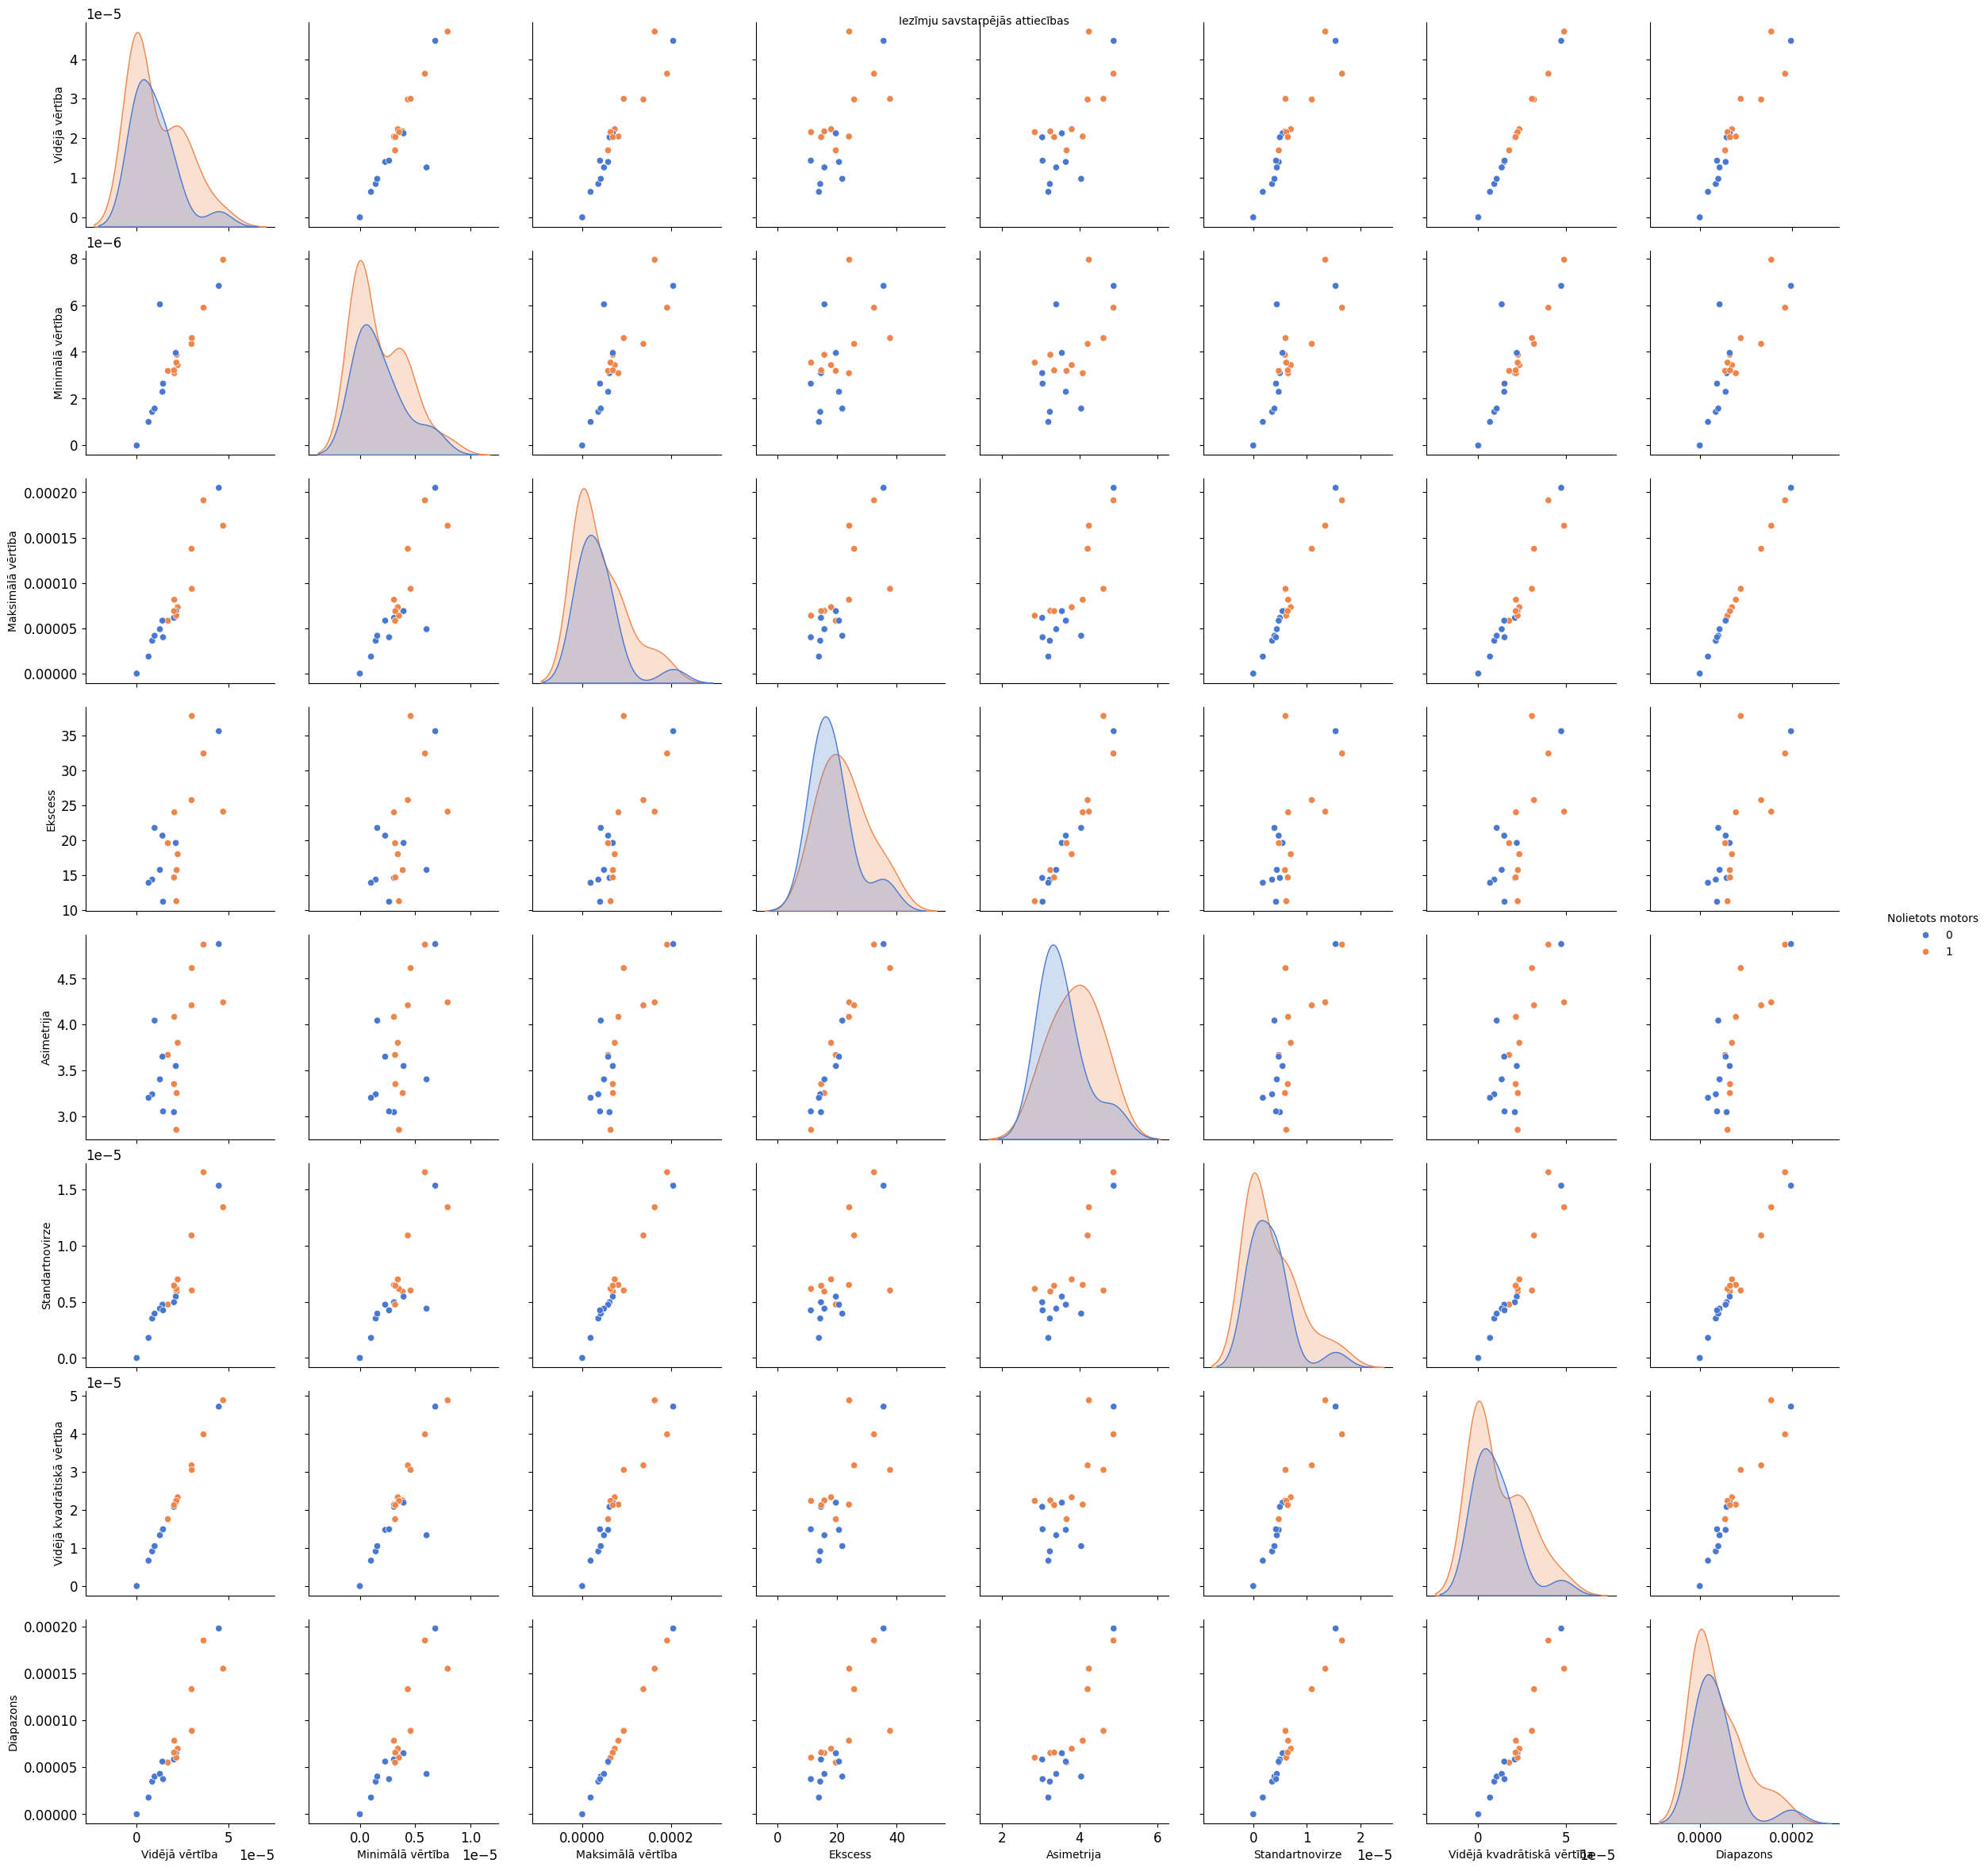

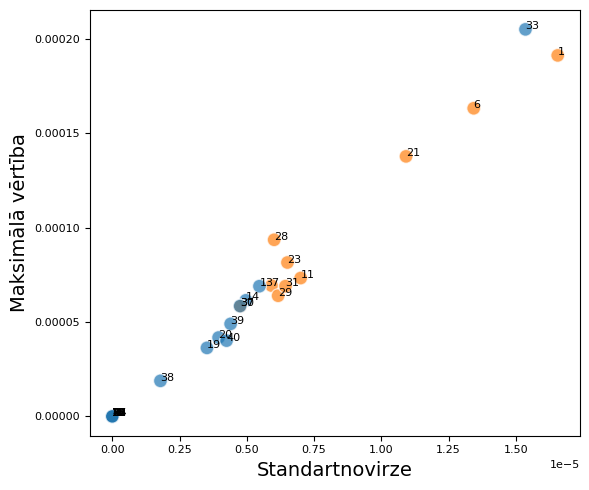

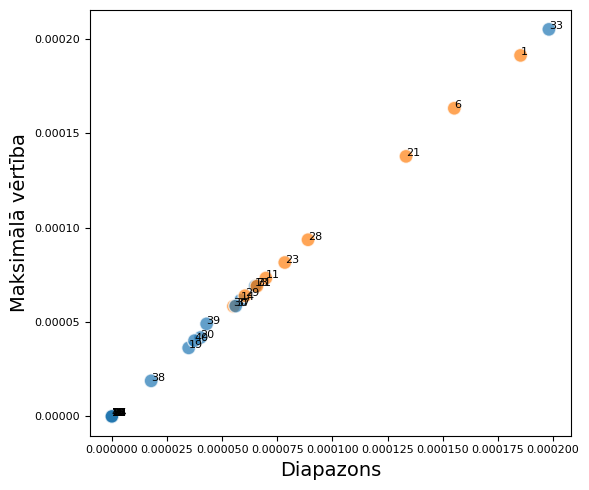

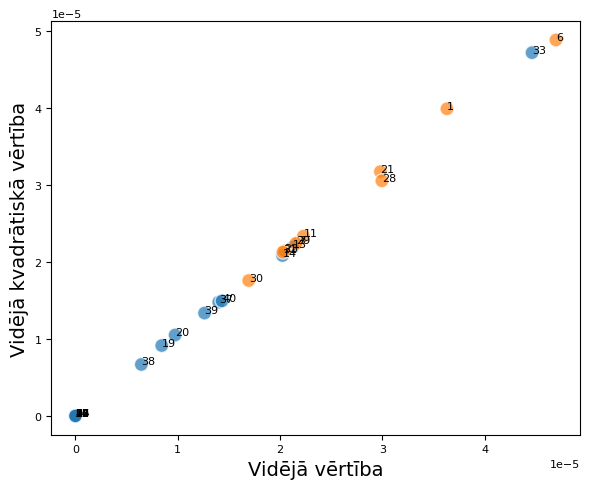

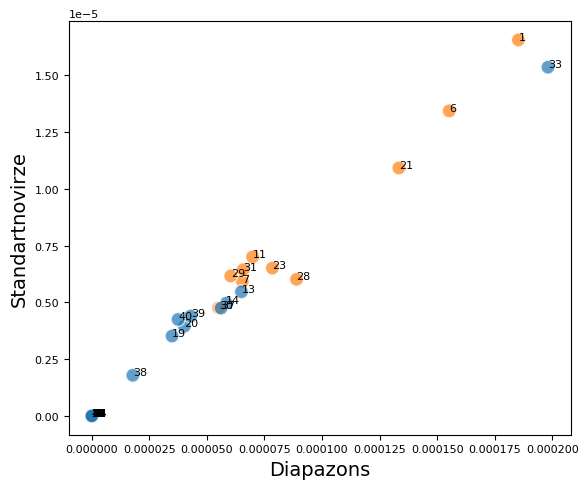

In [7]:
# Funkcija iezīmju aprēķināšanai
def extract_features(file_list, fs=7420):
    all_features = []
    shortest_length = None

    for file in file_list:
        # Nosaka īsākā signāla garumu
        data = pd.read_csv(file)
        values = data['Value'].values
        if shortest_length is None or len(values) < shortest_length:
            shortest_length = len(values)

    for file in file_list:
        data = pd.read_csv(file)
        microseconds = data['Microseconds'].values
        values = data['Value'].values

        # Signāla saīsināšana
        shortened_values = values[:shortest_length]

        # Izclecošo vērtību noņemšana
        z_scores = zscore(shortened_values)
        mask = np.abs(z_scores) < 3
        outliers_removed_values = shortened_values[mask]

        # Līdzkomponentes noņemšana
        processed_values = outliers_removed_values - np.mean(outliers_removed_values)

        # Jaudas spektrālā blīvuma aprēķināšana
        f, pxx = welch(processed_values, fs=fs, nperseg=min(1024, len(processed_values)))

        # Iezīmju aprēķināšana
        features = {
            'Vidējā vērtība': np.mean(pxx),
            'Minimālā vērtība': np.min(pxx),
            'Maksimālā vērtība': np.max(pxx),
            'Ekscess': kurtosis(pxx),
            'Asimetrija': skew(pxx),
            'Standartnovirze': np.std(pxx),
            'Vidējā kvadrātiskā vērtība': np.sqrt(np.mean(np.square(pxx))),
            'Diapazons': np.ptp(pxx),
        }

        all_features.append(features)

        print(f"Features {file}: {features}")

    return pd.DataFrame(all_features)

features_df = extract_features(file_list, fs=7420)

# Iezīmju savstarpējo attiecību grafiki

plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

features_df['Nolietots motors'] = [label[2] for label in labels]
prediction_class = 'Nolietots motors'
all_features = [column for column in features_df.columns if column != prediction_class]

pair_plot = sbn.pairplot(features_df, hue=prediction_class, palette="muted", height=3, vars=all_features)
plt.gcf().text(0.5, 0.98, 'Iezīmju savstarpējās attiecības', ha='center', va='center')
plt.show()

# Inviduālie grafiki
plt.rcParams.update({'xtick.labelsize': 8, 'ytick.labelsize': 8})
plt.rcParams.update({'axes.labelsize': 14})

plt.figure(figsize=(6, 5))
feature1_name = 'Standartnovirze'
feature2_name = 'Maksimālā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[2] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Diapazons'
feature2_name = 'Maksimālā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[2] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Vidējā vērtība'
feature2_name = 'Vidējā kvadrātiskā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[2] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Diapazons'
feature2_name = 'Standartnovirze'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[2] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()





### Ieplīsis stiprinājums

Features 16_May_15h_41m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 3.63233595703085e-05, 'Minimālā vērtība': 5.891728319002347e-06, 'Maksimālā vērtība': 0.00019117015828424877, 'Ekscess': 32.384700373970325, 'Asimetrija': 4.8733336029280725, 'Standartnovirze': 1.6560351230040787e-05, 'Vidējā kvadrātiskā vērtība': 3.992031667379701e-05, 'Diapazons': 0.00018527842996524641}
Features 16_May_15h_43m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Standartnovirze': 0.0, 'Vidējā kvadrātiskā vērtība': 0.0, 'Diapazons': 0.0}
Features 16_May_15h_49m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Standartnovirze': 0.0, 'Vidējā kvadrātiskā vērtība': 0.0, 'Diapazons': 0.0}
Features 16_May_15h_47m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Stan

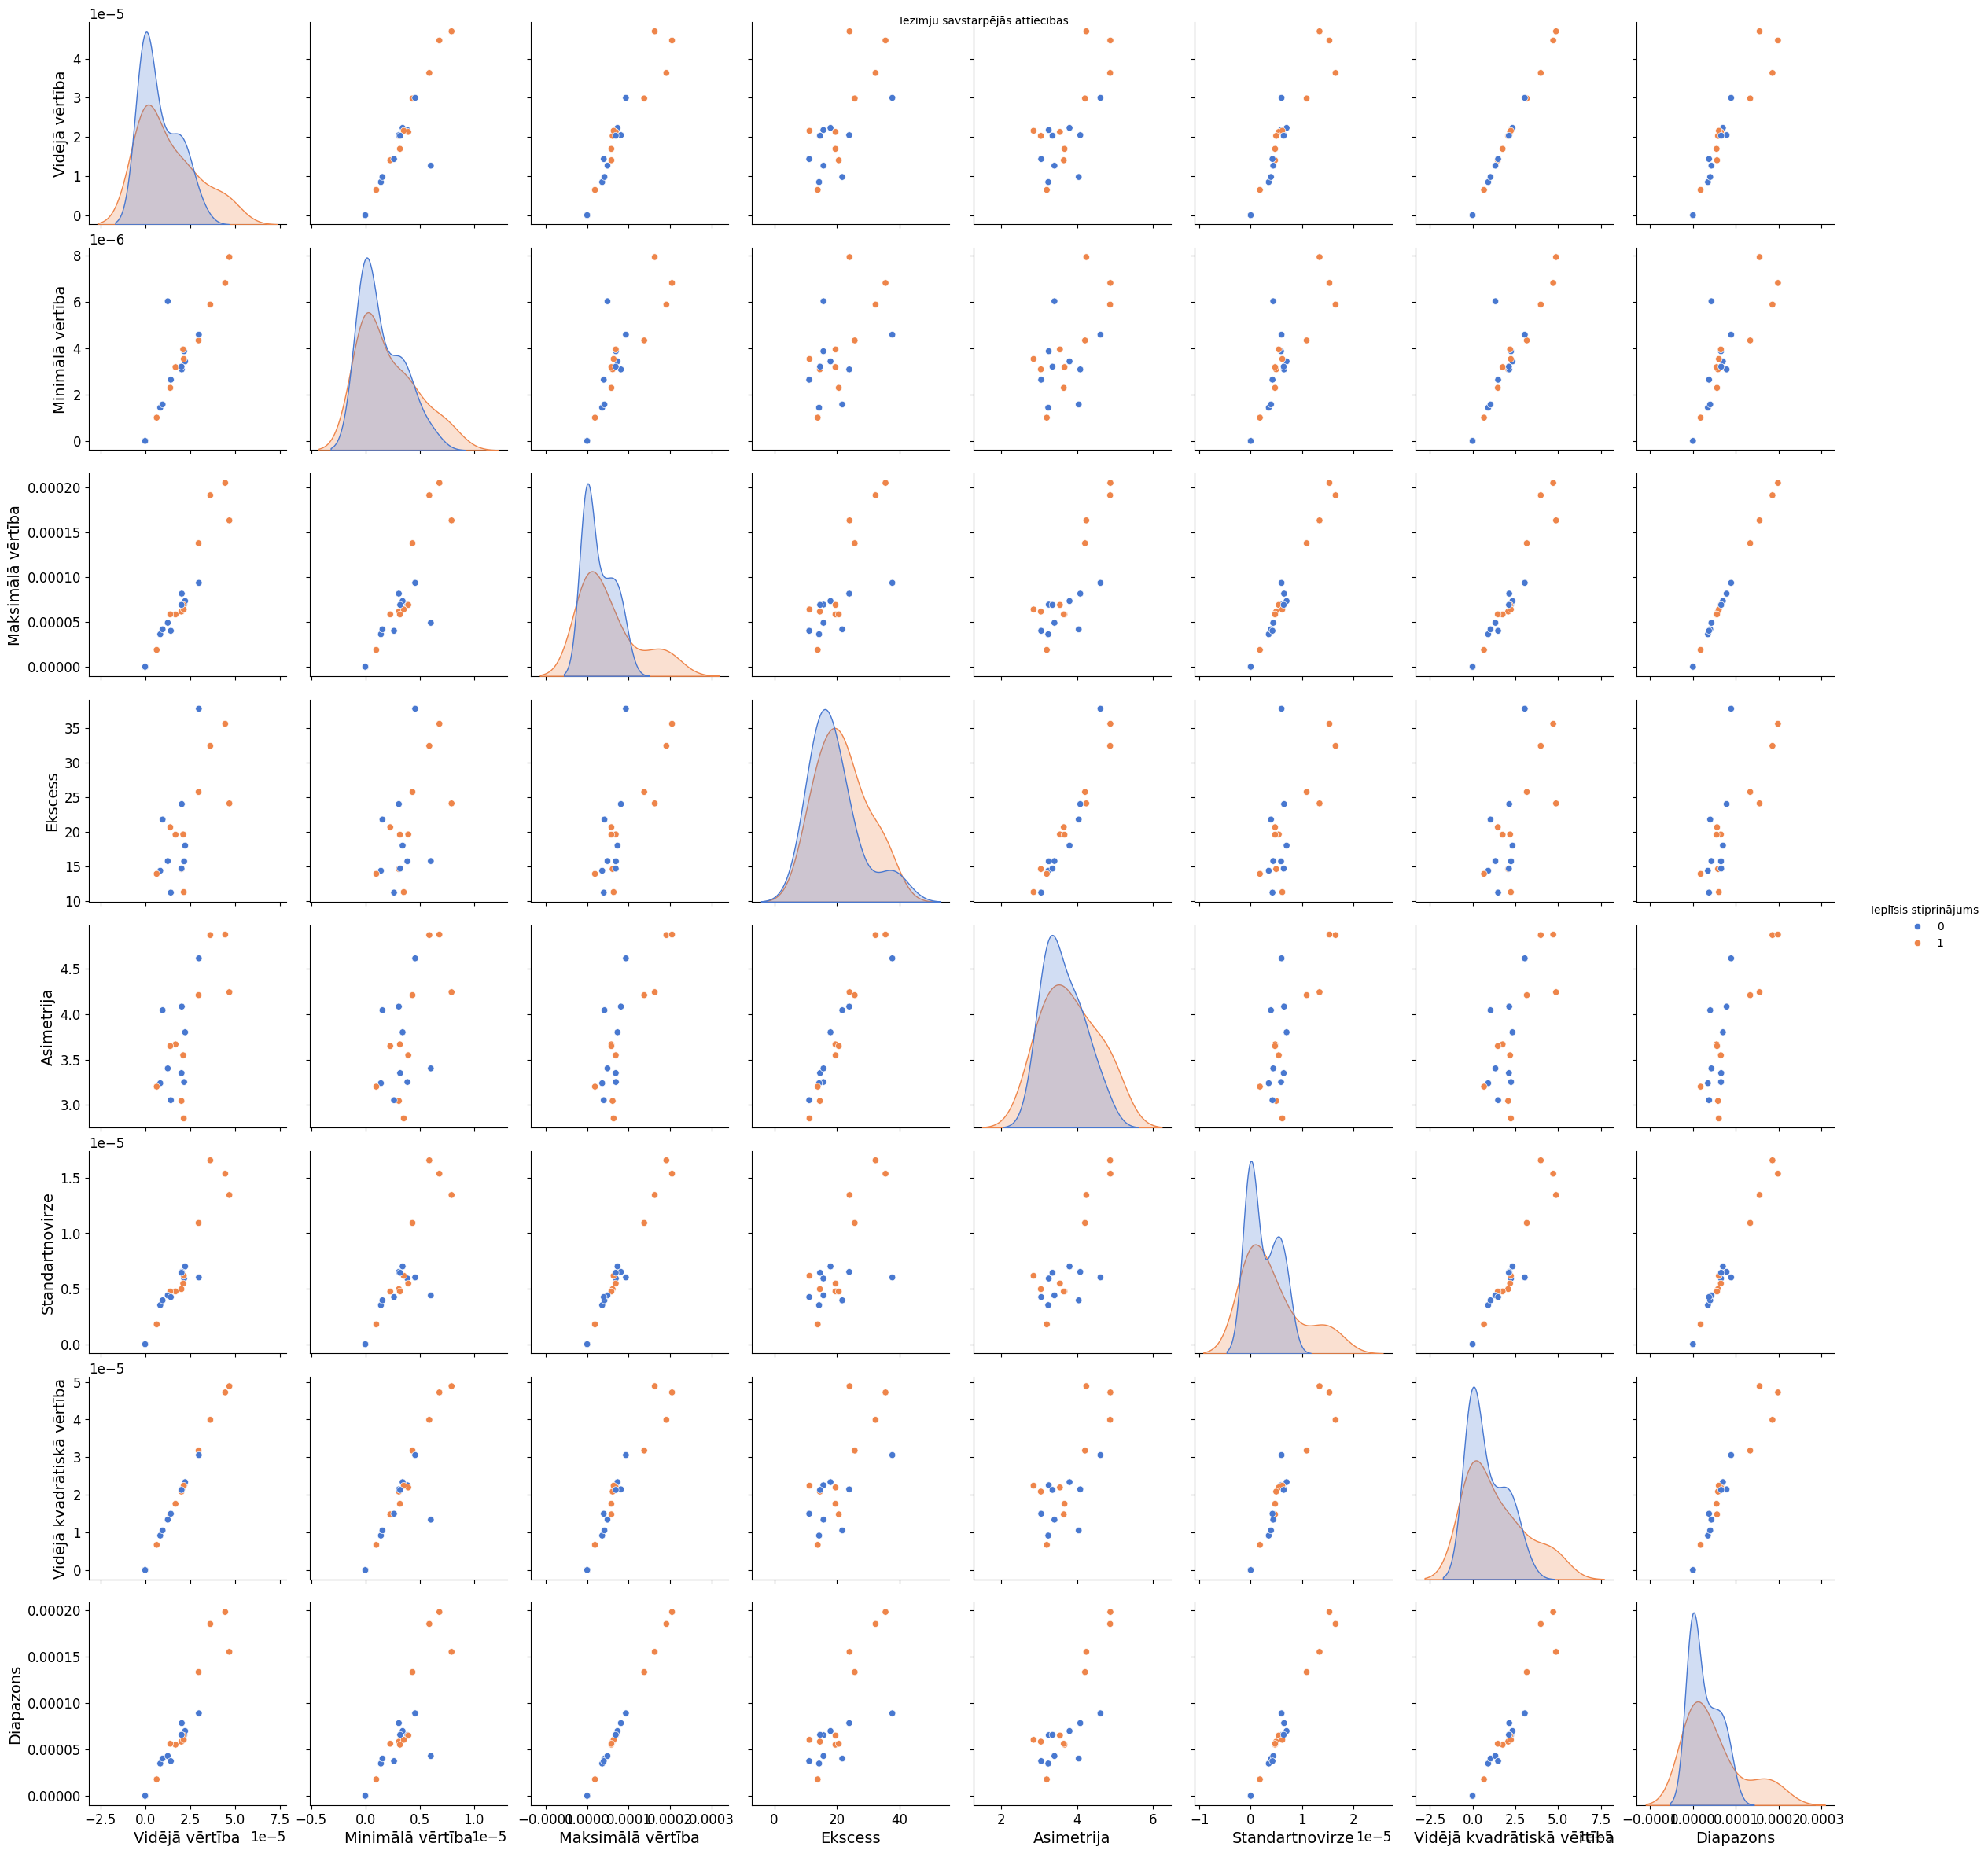

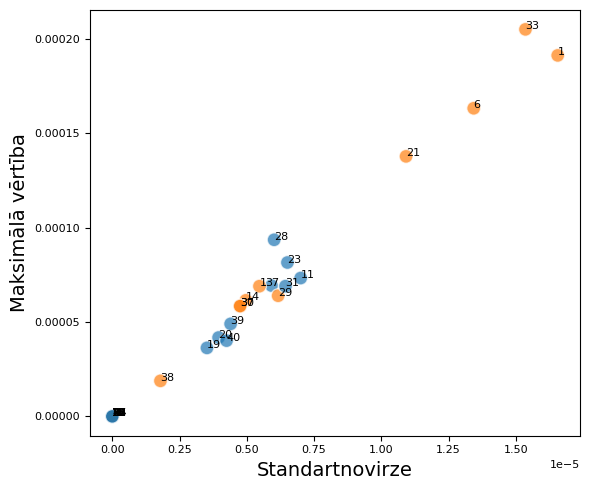

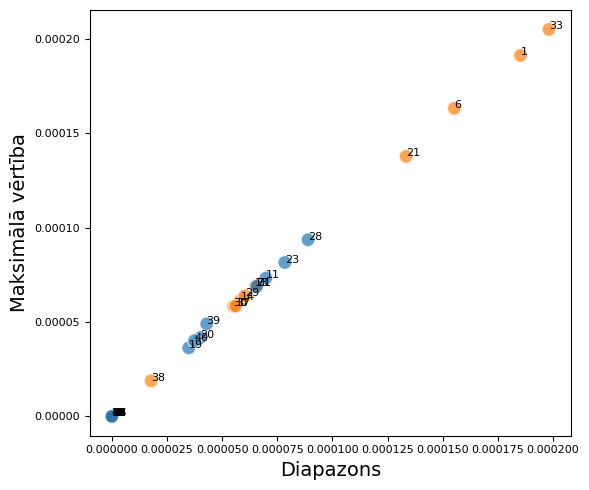

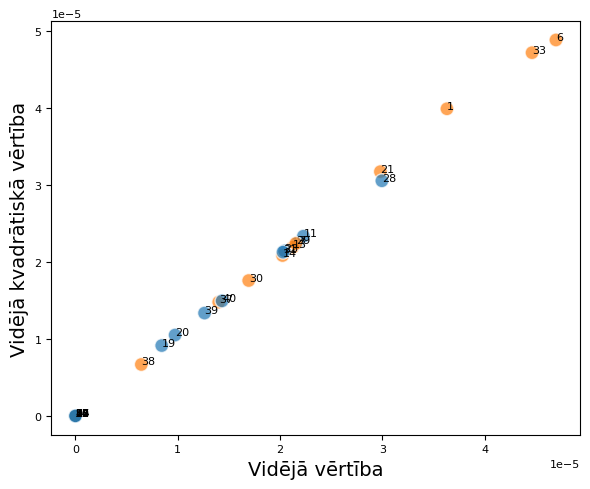

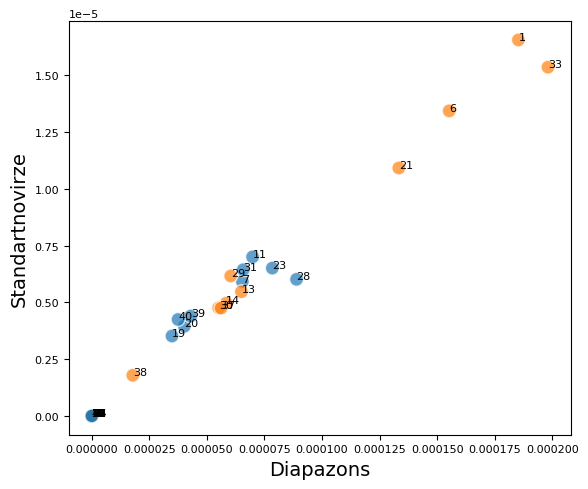

In [8]:
# Funkcija iezīmju aprēķināšanai
def extract_features(file_list, fs=7420):
    all_features = []
    shortest_length = None

    for file in file_list:
        # Nosaka īsākā signāla garumu
        data = pd.read_csv(file)
        values = data['Value'].values
        if shortest_length is None or len(values) < shortest_length:
            shortest_length = len(values)

    for file in file_list:
        data = pd.read_csv(file)
        microseconds = data['Microseconds'].values
        values = data['Value'].values

        # Signāla saīsināšana
        shortened_values = values[:shortest_length]

        # Izclecošo vērtību noņemšana
        z_scores = zscore(shortened_values)
        mask = np.abs(z_scores) < 3
        outliers_removed_values = shortened_values[mask]

        # Līdzkomponentes noņemšana
        processed_values = outliers_removed_values - np.mean(outliers_removed_values)

        # Jaudas spektrālā blīvuma aprēķināšana
        f, pxx = welch(processed_values, fs=fs, nperseg=min(1024, len(processed_values)))

        # Iezīmju aprēķināšana
        features = {
            'Vidējā vērtība': np.mean(pxx),
            'Minimālā vērtība': np.min(pxx),
            'Maksimālā vērtība': np.max(pxx),
            'Ekscess': kurtosis(pxx),
            'Asimetrija': skew(pxx),
            'Standartnovirze': np.std(pxx),
            'Vidējā kvadrātiskā vērtība': np.sqrt(np.mean(np.square(pxx))),
            'Diapazons': np.ptp(pxx),
        }

        all_features.append(features)

        print(f"Features {file}: {features}")

    return pd.DataFrame(all_features)

features_df = extract_features(file_list, fs=7420)

# Iezīmju savstarpējo attiecību grafiki

plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

features_df['Ieplīsis stiprinājums'] = [label[1] for label in labels]
prediction_class = 'Ieplīsis stiprinājums'
all_features = [column for column in features_df.columns if column != prediction_class]
pair_plot = sbn.pairplot(features_df, hue=prediction_class, palette="muted", height=3, vars=all_features)
plt.gcf().text(0.5, 0.98, 'Iezīmju savstarpējās attiecības', ha='center', va='center')
plt.show()

# Inviduālie grafiki
plt.rcParams.update({'xtick.labelsize': 8, 'ytick.labelsize': 8})
plt.rcParams.update({'axes.labelsize': 14})

plt.figure(figsize=(6, 5))
feature1_name = 'Standartnovirze'
feature2_name = 'Maksimālā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[1] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Diapazons'
feature2_name = 'Maksimālā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[1] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Vidējā vērtība'
feature2_name = 'Vidējā kvadrātiskā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[1] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Diapazons'
feature2_name = 'Standartnovirze'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[1] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()





### Pievienota slodze (ritenis)

Features 16_May_15h_41m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 3.63233595703085e-05, 'Minimālā vērtība': 5.891728319002347e-06, 'Maksimālā vērtība': 0.00019117015828424877, 'Ekscess': 32.384700373970325, 'Asimetrija': 4.8733336029280725, 'Standartnovirze': 1.6560351230040787e-05, 'Vidējā kvadrātiskā vērtība': 3.992031667379701e-05, 'Diapazons': 0.00018527842996524641}
Features 16_May_15h_43m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Standartnovirze': 0.0, 'Vidējā kvadrātiskā vērtība': 0.0, 'Diapazons': 0.0}
Features 16_May_15h_49m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Standartnovirze': 0.0, 'Vidējā kvadrātiskā vērtība': 0.0, 'Diapazons': 0.0}
Features 16_May_15h_47m_5.0V_2.2kOhm_log.csv: {'Vidējā vērtība': 0.0, 'Minimālā vērtība': 0.0, 'Maksimālā vērtība': 0.0, 'Ekscess': nan, 'Asimetrija': nan, 'Stan

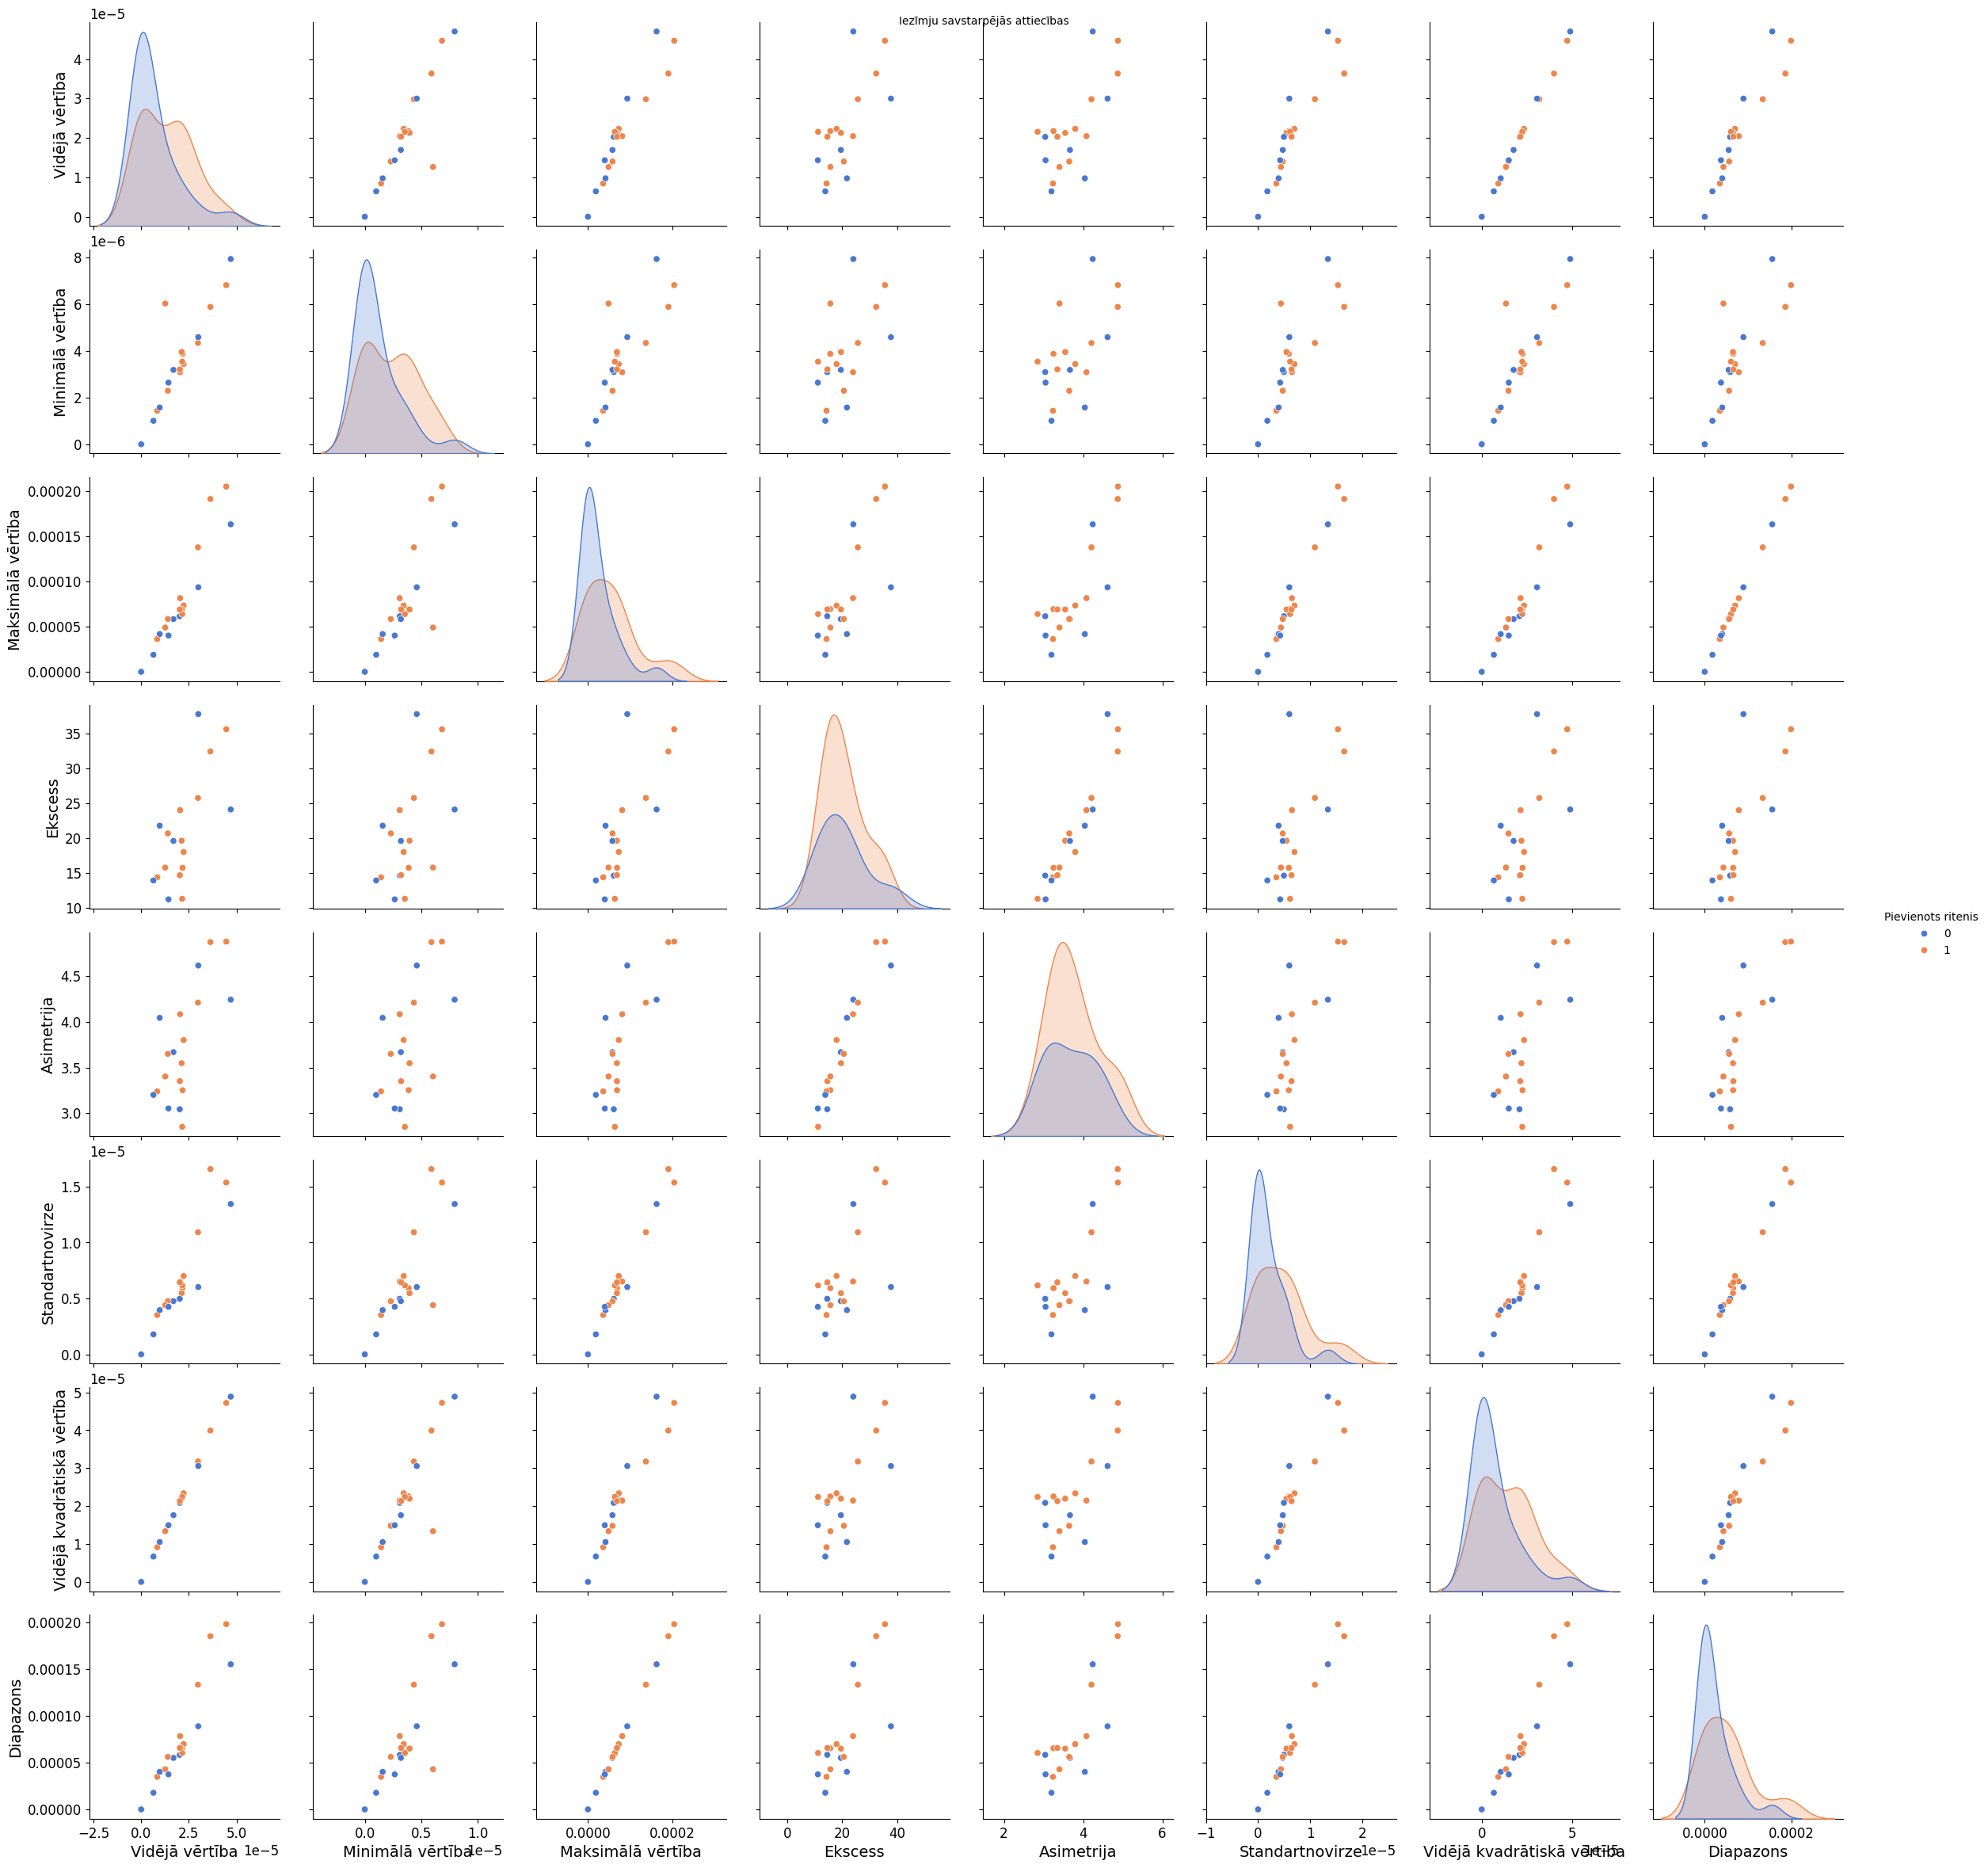

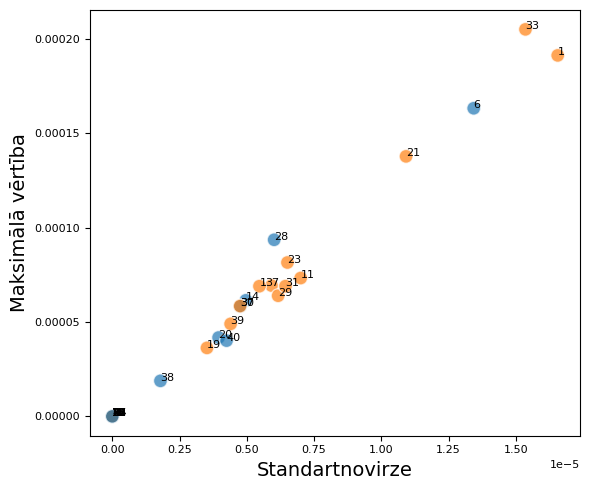

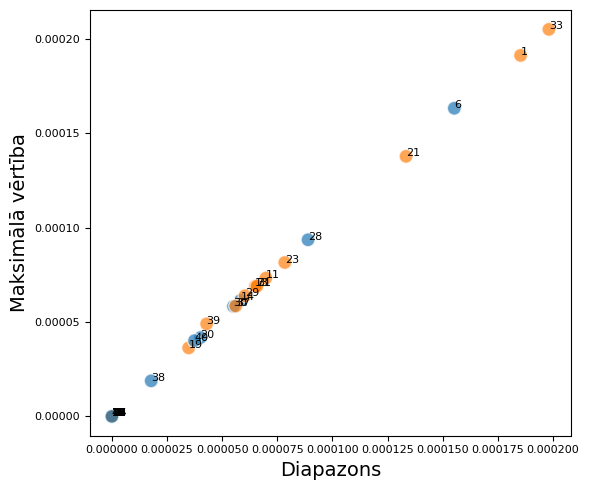

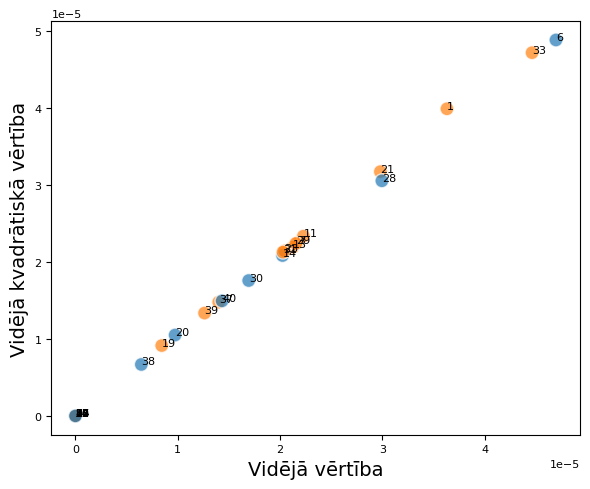

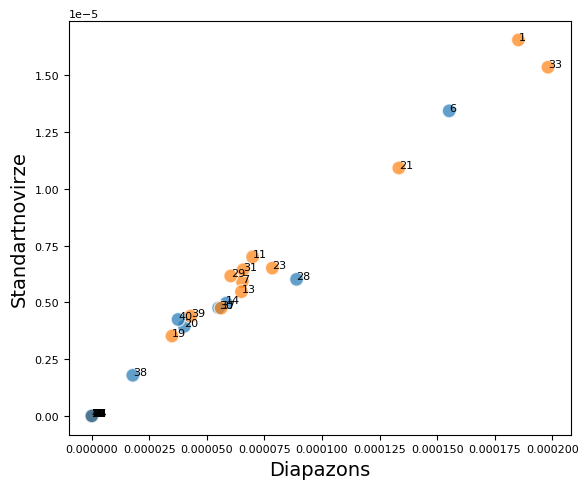

In [9]:
# Funkcija iezīmju aprēķināšanai
def extract_features(file_list, fs=7420):
    all_features = []
    shortest_length = None

    for file in file_list:
        # Nosaka īsākā signāla garumu
        data = pd.read_csv(file)
        values = data['Value'].values
        if shortest_length is None or len(values) < shortest_length:
            shortest_length = len(values)

    for file in file_list:
        data = pd.read_csv(file)
        microseconds = data['Microseconds'].values
        values = data['Value'].values

        # Signāla saīsināšana
        shortened_values = values[:shortest_length]

        # Izclecošo vērtību noņemšana
        z_scores = zscore(shortened_values)
        mask = np.abs(z_scores) < 3
        outliers_removed_values = shortened_values[mask]

        # Līdzkomponentes noņemšana
        processed_values = outliers_removed_values - np.mean(outliers_removed_values)

        # Jaudas spektrālā blīvuma aprēķināšana
        f, pxx = welch(processed_values, fs=fs, nperseg=min(1024, len(processed_values)))

        # Iezīmju aprēķināšana
        features = {
            'Vidējā vērtība': np.mean(pxx),
            'Minimālā vērtība': np.min(pxx),
            'Maksimālā vērtība': np.max(pxx),
            'Ekscess': kurtosis(pxx),
            'Asimetrija': skew(pxx),
            'Standartnovirze': np.std(pxx),
            'Vidējā kvadrātiskā vērtība': np.sqrt(np.mean(np.square(pxx))),
            'Diapazons': np.ptp(pxx),
        }

        all_features.append(features)

        print(f"Features {file}: {features}")

    return pd.DataFrame(all_features)

features_df = extract_features(file_list, fs=7420)

# Iezīmju savstarpējo attiecību grafiki

plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

features_df['Pievienots ritenis'] = [label[0] for label in labels]
prediction_class = 'Pievienots ritenis'
all_features = [column for column in features_df.columns if column != prediction_class]
pair_plot = sbn.pairplot(features_df, hue=prediction_class, palette="muted", height=3, vars=all_features)
plt.gcf().text(0.5, 0.98, 'Iezīmju savstarpējās attiecības', ha='center', va='center')
plt.show()

# Inviduālie grafiki
plt.rcParams.update({'xtick.labelsize': 8, 'ytick.labelsize': 8})
plt.rcParams.update({'axes.labelsize': 14})

plt.figure(figsize=(6, 5))
feature1_name = 'Standartnovirze'
feature2_name = 'Maksimālā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[0] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Diapazons'
feature2_name = 'Maksimālā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[0] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Vidējā vērtība'
feature2_name = 'Vidējā kvadrātiskā vērtība'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[0] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
feature1_name = 'Diapazons'
feature2_name = 'Standartnovirze'
feature1_values = features_df[feature1_name]
feature2_values = features_df[feature2_name]
colors = ['tab:orange' if label[0] == 1 else 'tab:blue' for label in labels]
plt.scatter(feature1_values, feature2_values, c=colors, alpha=0.7, edgecolors='w', s=100)
# Punktu indeksi
for j, txt in enumerate(range(len(file_list))):
    plt.annotate(txt + 1, (feature1_values[j], feature2_values[j]), fontsize=8)
plt.xlabel(feature1_name)
plt.ylabel(feature2_name)
plt.tight_layout()
plt.show()





## Klasifikācija

In [10]:
# Atjaunotā datu kopa un iezīmes

file_list = [
    "16_May_15h_41m_5.0V_2.2kOhm_log.csv",
    "16_May_15h_58m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_04m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_16m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_27m_5.0V_2.2kOhm_log.csv",
    "16_May_16h_25m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_33m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_35m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_46m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_55m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_14m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_19m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_18m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_22m_5.0V_2.2kOhm_log.csv",
    "16_May_17h_20m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_32m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_28m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_35m_5.0V_2.2kOhm_log.csv",
    "16_May_18h_36m_5.0V_2.2kOhm_log.csv"
]

labels = [
    [1, 1, 1],
    [0, 1, 1],
    [1, 0, 1],
    [1, 0, 1],
    [1, 1, 0],
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0],
    [1, 1, 1],
    [1, 0, 1],
    [0, 0, 1],
    [1, 1, 1],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 0],
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
]


### Klasifikācija pēc motora nolietojuma

Metrikas:
Precizitāte (accuracy): 0.7875000000000001
Pozitīvā prognozējošā vērtība (precision): 0.8166666666666667
Jutīgums (recall): 0.875
F1 vērtība: 0.8041666666666666


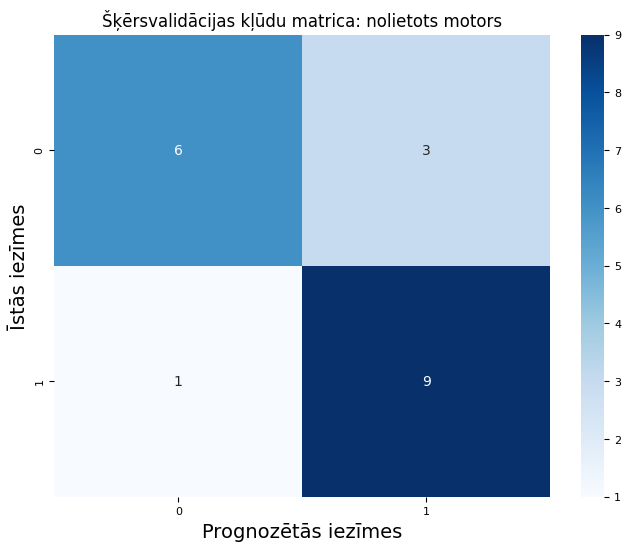

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, kurtosis, skew
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Funkcija iezīmju aprēķināšanai
def extract_features(file_list, fs=7420):
    all_features = []
    shortest_length = None

    for file in file_list:
        # Nosaka īsākā signāla garumu
        data = pd.read_csv(file)
        values = data['Value'].values
        if shortest_length is None or len(values) < shortest_length:
            shortest_length = len(values)

    for file in file_list:
        data = pd.read_csv(file)
        microseconds = data['Microseconds'].values
        values = data['Value'].values

        # Signāla saīsināšana
        shortened_values = values[:shortest_length]

        # Izclecošo vērtību noņemšana
        z_scores = zscore(shortened_values)
        mask = np.abs(z_scores) < 3
        outliers_removed_values = shortened_values[mask]

        # Līdzkomponentes noņemšana
        processed_values = outliers_removed_values - np.mean(outliers_removed_values)

        # Jaudas spektrālā blīvuma aprēķināšana
        f, pxx = welch(processed_values, fs=fs, nperseg=min(1024, len(processed_values)))

        # Iezīmju aprēķināšana
        features = {
            'Vidējā vērtība': np.mean(pxx),
            'Maksimālā vērtība': np.max(pxx),
            'Standartnovirze': np.std(pxx),
            'Vidējā kvadrātiskā vērtība': np.sqrt(np.mean(np.square(pxx))),
            'Diapazons': np.ptp(pxx),
        }

        all_features.append(features)

    return pd.DataFrame(all_features)

# Iezīmes un izmantot motora nolietojumu
x = extract_features(file_list, fs=7420)
y = np.array([label[2] for label in labels])

random_forest = RandomForestClassifier(n_estimators=20, min_samples_split=3, random_state=42)

# šķērsvalidācija
cv_results = cross_validate(random_forest, x, y, cv=4, scoring=['accuracy', 'precision', 'recall', 'f1'])

# Vidējās metrikas
print("Metrikas:")
print("Precizitāte (accuracy):", np.mean(cv_results['test_accuracy']))
print("Pozitīvā prognozējošā vērtība (precision):", np.mean(cv_results['test_precision']))
print("Jutīgums (recall):", np.mean(cv_results['test_recall']))
print("F1 vērtība:", np.mean(cv_results['test_f1']))

# Kļūdu matrica
y_pred_confusion = cross_val_predict(random_forest, x, y, cv=4)
conf_mat = confusion_matrix(y, y_pred_confusion)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Prognozētās iezīmes')
plt.ylabel('Īstās iezīmes')
plt.title('Šķērsvalidācijas kļūdu matrica: nolietots motors')
plt.show()


### Klasifikācija pēc stiprinājuma

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrikas:
Precizitāte (accuracy): 0.6875
Pozitīvā prognozējošā vērtība (precision): 0.6666666666666666
Jutīgums (recall): 0.5416666666666666
F1 vērtība: 0.5666666666666667


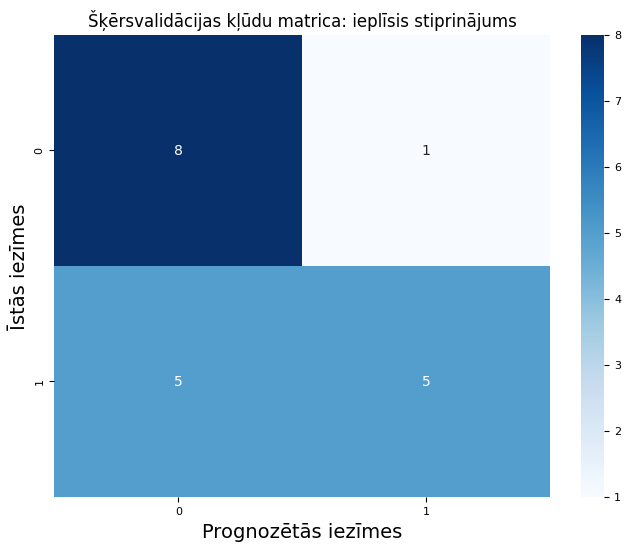

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, kurtosis, skew
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Funkcija iezīmju aprēķināšanai
def extract_features(file_list, fs=7420):
    all_features = []
    shortest_length = None

    for file in file_list:
        # Nosaka īsākā signāla garumu
        data = pd.read_csv(file)
        values = data['Value'].values
        if shortest_length is None or len(values) < shortest_length:
            shortest_length = len(values)

    for file in file_list:
        data = pd.read_csv(file)
        microseconds = data['Microseconds'].values
        values = data['Value'].values

        # Signāla saīsināšana
        shortened_values = values[:shortest_length]

        # Izclecošo vērtību noņemšana
        z_scores = zscore(shortened_values)
        mask = np.abs(z_scores) < 3
        outliers_removed_values = shortened_values[mask]

        # Līdzkomponentes noņemšana
        processed_values = outliers_removed_values - np.mean(outliers_removed_values)

        # Jaudas spektrālā blīvuma aprēķināšana
        f, pxx = welch(processed_values, fs=fs, nperseg=min(1024, len(processed_values)))

        # Iezīmju aprēķināšana
        features = {
            'Vidējā vērtība': np.mean(pxx),
            'Maksimālā vērtība': np.max(pxx),
            'Standartnovirze': np.std(pxx),
            'Vidējā kvadrātiskā vērtība': np.sqrt(np.mean(np.square(pxx))),
            'Diapazons': np.ptp(pxx),
        }

        all_features.append(features)

    return pd.DataFrame(all_features)

# Iezīmes un izmantot stiprinājuma pazīmi
x = extract_features(file_list, fs=7420)
y = np.array([label[1] for label in labels])

random_forest = RandomForestClassifier(n_estimators=20, min_samples_split=3, random_state=42)

# šķērsvalidācija
cv_results = cross_validate(random_forest, x, y, cv=4, scoring=['accuracy', 'precision', 'recall', 'f1'])

# Vidējās metrikas
print("Metrikas:")
print("Precizitāte (accuracy):", np.mean(cv_results['test_accuracy']))
print("Pozitīvā prognozējošā vērtība (precision):", np.mean(cv_results['test_precision']))
print("Jutīgums (recall):", np.mean(cv_results['test_recall']))
print("F1 vērtība:", np.mean(cv_results['test_f1']))

# Kļūdu matrica
y_pred_confusion = cross_val_predict(random_forest, x, y, cv=4)
conf_mat = confusion_matrix(y, y_pred_confusion)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Prognozētās iezīmes')
plt.ylabel('Īstās iezīmes')
plt.title('Šķērsvalidācijas kļūdu matrica: ieplīsis stiprinājums')
plt.show()


### Klasifikācija pēc pievienota riteņa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrikas:
Precizitāte (accuracy): 0.5125
Pozitīvā prognozējošā vērtība (precision): 0.4666666666666667
Jutīgums (recall): 0.6666666666666666
F1 vērtība: 0.5416666666666666


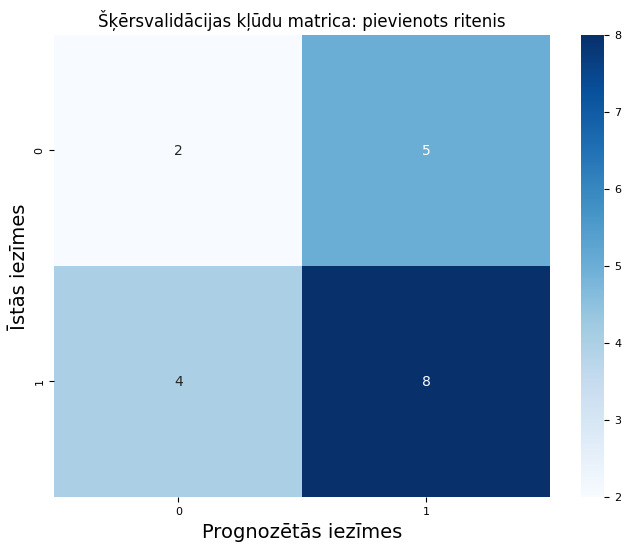

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, kurtosis, skew
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Funkcija iezīmju aprēķināšanai
def extract_features(file_list, fs=7420):
    all_features = []
    shortest_length = None

    for file in file_list:
        # Nosaka īsākā signāla garumu
        data = pd.read_csv(file)
        values = data['Value'].values
        if shortest_length is None or len(values) < shortest_length:
            shortest_length = len(values)

    for file in file_list:
        data = pd.read_csv(file)
        microseconds = data['Microseconds'].values
        values = data['Value'].values

        # Signāla saīsināšana
        shortened_values = values[:shortest_length]

        # Izclecošo vērtību noņemšana
        z_scores = zscore(shortened_values)
        mask = np.abs(z_scores) < 3
        outliers_removed_values = shortened_values[mask]

        # Līdzkomponentes noņemšana
        processed_values = outliers_removed_values - np.mean(outliers_removed_values)

        # Jaudas spektrālā blīvuma aprēķināšana
        f, pxx = welch(processed_values, fs=fs, nperseg=min(1024, len(processed_values)))

        # Iezīmju aprēķināšana
        features = {
            'Vidējā vērtība': np.mean(pxx),
            'Maksimālā vērtība': np.max(pxx),
            'Standartnovirze': np.std(pxx),
            'Vidējā kvadrātiskā vērtība': np.sqrt(np.mean(np.square(pxx))),
            'Diapazons': np.ptp(pxx),
        }

        all_features.append(features)

    return pd.DataFrame(all_features)

# Iezīmes un izmantot pievienoto ritena pazīmi
x = extract_features(file_list, fs=7420)
y = np.array([label[0] for label in labels])

random_forest = RandomForestClassifier(n_estimators=20, min_samples_split=3, random_state=42)

# šķērsvalidācija
cv_results = cross_validate(random_forest, x, y, cv=4, scoring=['accuracy', 'precision', 'recall', 'f1'])

# Vidējās metrikas
print("Metrikas:")
print("Precizitāte (accuracy):", np.mean(cv_results['test_accuracy']))
print("Pozitīvā prognozējošā vērtība (precision):", np.mean(cv_results['test_precision']))
print("Jutīgums (recall):", np.mean(cv_results['test_recall']))
print("F1 vērtība:", np.mean(cv_results['test_f1']))

# Kļūdu matrica
y_pred_confusion = cross_val_predict(random_forest, x, y, cv=4)
conf_mat = confusion_matrix(y, y_pred_confusion)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Prognozētās iezīmes')
plt.ylabel('Īstās iezīmes')
plt.title('Šķērsvalidācijas kļūdu matrica: pievienots ritenis')
plt.show()
